In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch

from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from segmentation_utils.dataloader import ImageCircleDatasetV2, ImageCircleDatasetSeperate

/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
SAM2ImagePredictor?

Init signature:
SAM2ImagePredictor(
    sam_model: sam2.modeling.sam2_base.SAM2Base,
    mask_threshold=0.0,
    max_hole_area=0.0,
    max_sprinkle_area=0.0,
    **kwargs,
) -> None
Docstring:      <no docstring>
Init docstring:
Uses SAM-2 to calculate the image embedding for an image, and then
allow repeated, efficient mask prediction given prompts.

Arguments:
  sam_model (Sam-2): The model to use for mask prediction.
  mask_threshold (float): The threshold to use when converting mask logits
    to binary masks. Masks are thresholded at 0 by default.
  max_hole_area (int): If max_hole_area > 0, we fill small holes in up to
    the maximum area of max_hole_area in low_res_masks.
  max_sprinkle_area (int): If max_sprinkle_area > 0, we remove small sprinkles up to
    the maximum area of max_sprinkle_area in low_res_masks.
File:           ~/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/sam2/sam2_image_predictor.py
Type:           type
Subclasses:     

In [4]:

# 1. Load the pretrained model
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")  # :contentReference[oaicite:0]{index=0}

# 2. Read your image

# masks is a list of boolean arrays (H×W), one per prompt; 
# scores gives a confidence per mask.



In [5]:
import segmentation_models_pytorch as smp

model_pronuclei = smp.Unet(
    encoder_name="mit_b5",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)
model_pronuclei.load_state_dict(
    torch.load(
        "/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/multiclass_u-mit_b5.pt",
        weights_only=True,
    )
)

<All keys matched successfully>

In [26]:
image_pil = Image.open("/home/tsakalis/ntua/phd/cellforge/cellforge/data/D2016.07.08_S1366_I149_11/140.jpg").convert("RGB")

In [ ]:
dataset  =ImageCircleDatasetSeperate([image_pil],[{}],[image_pil],predict=True)
img,_ = dataset[0]

#

In [28]:
predicted_masks = model_pronuclei(img.unsqueeze(0))

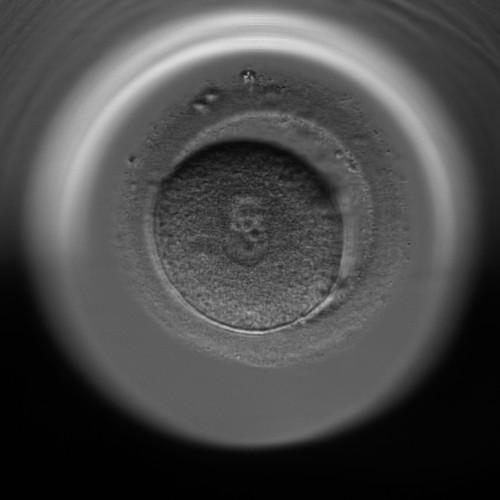

In [29]:



image_pil

In [30]:
import seaborn as sns

<Axes: >

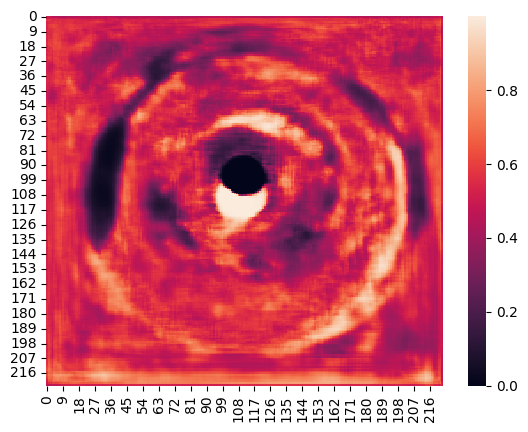

In [40]:
sns.heatmap(torch.sigmoid(predicted_masks[0][1]).detach())

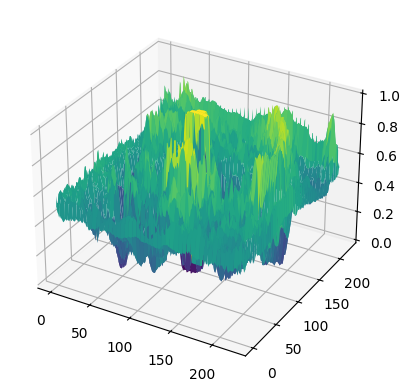

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np

# Assuming predicted_masks[0][1] is a torch tensor
Z = torch.sigmoid(predicted_masks[0][1]).detach().cpu().numpy()
X = np.arange(Z.shape[1])
Y = np.arange(Z.shape[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')  # You can choose other colormaps too
plt.show()


In [11]:
msk1 = torch.sigmoid(predicted_masks[0][1]).detach().numpy()>0.9
msk2 = torch.sigmoid(predicted_masks[0][2]).detach().numpy()>0.9

msk1 = np.array(Image.fromarray(msk1).resize((500, 500), Image.NEAREST))

msk2 = np.array(Image.fromarray(msk2).resize((500, 500), Image.NEAREST))

msk1_inpt = np.array(Image.fromarray(msk1).resize((256, 256), Image.NEAREST))

msk2_inpt = np.array(Image.fromarray(msk2).resize((256, 256), Image.NEAREST))


In [83]:
from PIL import Image


In [84]:
def get_sample_coords(mask):
    ys, xs = np.nonzero(mask.astype(int))

    # stack into an array of (x, y) coords
    coords = np.stack((xs, ys), axis=1)  # shape (N_true, 2), columns = x, y

    # sample k random coords without replacement
    k = 10  # number of samples you want
    idx = np.random.choice(len(coords), size=k, replace=False)
    sampled_coords = coords[idx].tolist()
    
    return sampled_coords


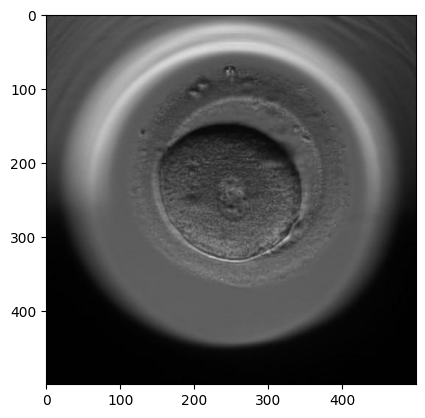

In [85]:
plt.imshow(image_pil)

In [86]:
msk1.shape

(500, 500)

In [87]:
sampled_coords

NameError: name 'sampled_coords' is not defined

In [88]:
import numpy as np

def get_sample_coords(mask: np.ndarray, k: int = 1) -> np.ndarray:
    """
    Sample up to k random (x, y) coordinates where mask is True.
    Returns an array of shape (n_samples, 2), columns = [x, y].
    """
    # find all true positions (y, x)
    ys, xs = np.nonzero(mask)
    coords = np.stack((xs, ys), axis=1)  # shape (N_true, 2)
    if coords.shape[0] == 0:
        return np.zeros((0, 2), dtype=int)
    # sample without replacement
    k = min(k, coords.shape[0])
    idx = np.random.choice(coords.shape[0], size=k, replace=False)
    return coords[idx]

# Example usage in your pipeline:
# --------------------------------
# 1. set your image on the predictor
predictor.set_image(np.array(image_pil))

# 2. sample points from two masks (foreground and background)
sampled_coords1 = get_sample_coords(msk1, k=5)   # 1 fg point
sampled_coords2 = get_sample_coords(msk2, k=5)   # 1 bg point

# 3. build point prompts
prompts = {
    "points":       sampled_coords1.tolist() + sampled_coords2.tolist(),
    "point_labels": [1]*len(sampled_coords1)    + [1]*len(sampled_coords2)
}

# 4. run prediction
masks, scores, logits = predictor.predict(
    prompts["points"],
    prompts["point_labels"],
    # mask_input = msk2_inpt[None,...]
)


In [89]:
msk1_inpt[None, ...].shape

(1, 256, 256)

In [90]:
predictor.predict?

Signature:
predictor.predict(
    point_coords: Optional[numpy.ndarray] = None,
    point_labels: Optional[numpy.ndarray] = None,
    box: Optional[numpy.ndarray] = None,
    mask_input: Optional[numpy.ndarray] = None,
    multimask_output: bool = True,
    return_logits: bool = False,
    normalize_coords=True,
) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
Docstring:
Predict masks for the given input prompts, using the currently set image.

Arguments:
  point_coords (np.ndarray or None): A Nx2 array of point prompts to the
    model. Each point is in (X,Y) in pixels.
  point_labels (np.ndarray or None): A length N array of labels for the
    point prompts. 1 indicates a foreground point and 0 indicates a
    background point.
  box (np.ndarray or None): A length 4 array given a box prompt to the
    model, in XYXY format.
  mask_input (np.ndarray): A low resolution mask input to the model, typically
    coming from a previous prediction iteration. Has form 1xHxW, where
    f

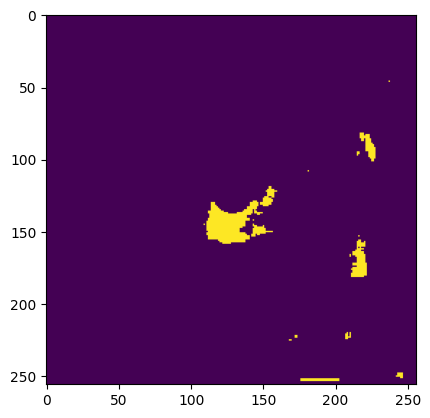

In [91]:
plt.imshow(msk1_inpt[None,...][0])

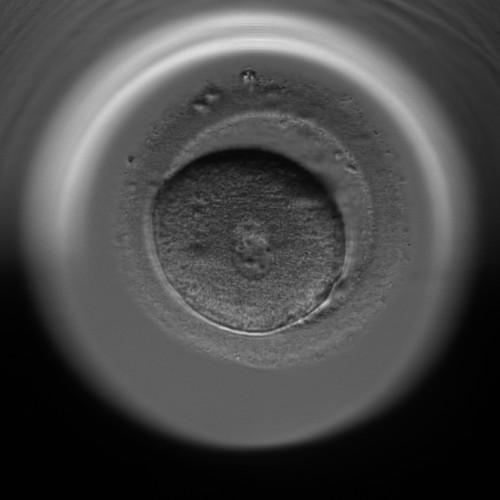

In [92]:
image_pil

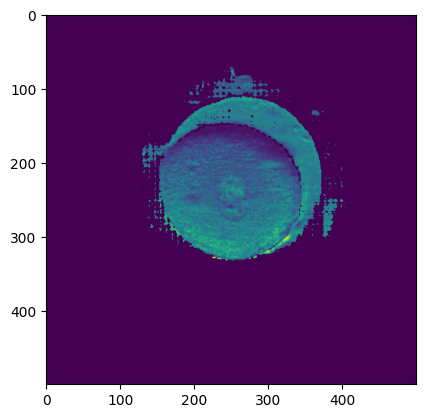

In [93]:
plt.imshow(masks[0]*np.array(image_pil)[...,0])

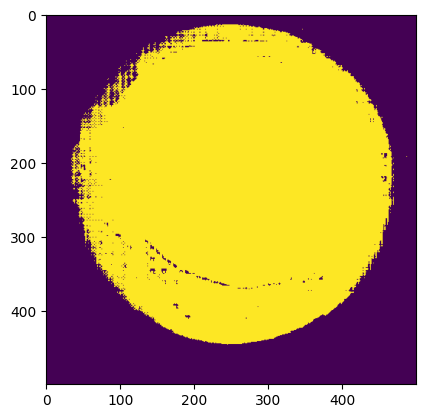

In [96]:
plt.imshow(masks[2])